In [6]:
import basedosdados as bd
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
query = """
    SELECT
    dados.id as id,
    dados.title as title,
    dados.link as link,
    dados.year as year,
    dados.duration as duration,
    dados.rating_mpa as rating_mpa,
    dados.rating_imdb as rating_imdb,
    dados.vote as vote,
    dados.budget as budget,
    dados.gross_world_wide as gross_world_wide,
    dados.gross_us_canada as gross_us_canada,
    dados.gross_opening_weekend as gross_opening_weekend,
    dados.director as director,
    dados.writer as writer,
    dados.star as star,
    dados.genre as genre,
    dados.country_origin as country_origin,
    dados.filming_location as filming_location,
    dados.production_company as production_company,
    dados.language as language,
    dados.win as win,
    dados.nomination as nomination,
    dados.oscar as oscar
FROM `basedosdados.world_imdb_movies.top_movies_per_year` AS dados
"""

df = bd.read_sql(query, billing_project_id="e-health-416317")


Downloading: 100%|██████████|


# Análise e Preparação dos Dados

## A) Explorando os dados

In [3]:
# Visualizando informações gerais sobre o DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33600 entries, 0 to 33599
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     33600 non-null  object 
 1   title                  33600 non-null  object 
 2   link                   33600 non-null  object 
 3   year                   33600 non-null  Int64  
 4   duration               33379 non-null  object 
 5   rating_mpa             25624 non-null  object 
 6   rating_imdb            33462 non-null  float64
 7   vote                   33462 non-null  Int64  
 8   budget                 11815 non-null  float64
 9   gross_world_wide       18222 non-null  float64
 10  gross_us_canada        17571 non-null  float64
 11  gross_opening_weekend  15523 non-null  float64
 12  director               33241 non-null  object 
 13  writer                 32024 non-null  object 
 14  star                   33127 non-null  object 
 15  ge

## B) Escolhendo um Melhor Alvo para Previsão

A previsão do número de Oscars mostrou-se desafiadora, com uma acurácia máxima de apenas 26,83%. Vamos explorar uma alternativa melhor: a previsão da categoria de avaliação do IMDb.

Distribuição de filmes por categoria de avaliação:
rating_category
médio    20137
alto      7722
baixo     5603
Name: count, dtype: int64


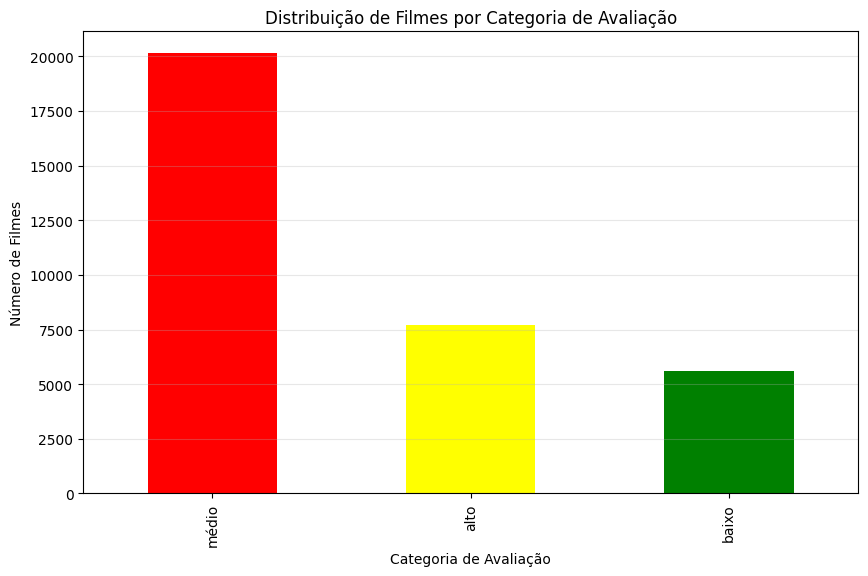

In [7]:
# Primeiro, vamos criar categorias para as notas do IMDb
# Se a coluna 'rating_category' não existir, vamos criá-la
if 'rating_category' not in df.columns:
    df['rating_category'] = pd.cut(df['rating_imdb'], 
                                 bins=[0, 5.0, 7.0, 10.0], 
                                 labels=['baixo', 'médio', 'alto'])

# Verificando a distribuição das categorias de avaliação
rating_counts = df['rating_category'].value_counts()
print("Distribuição de filmes por categoria de avaliação:")
print(rating_counts)

# Visualizando a distribuição
plt.figure(figsize=(10, 6))
rating_counts.plot(kind='bar', color=['red', 'yellow', 'green'])
plt.title('Distribuição de Filmes por Categoria de Avaliação')
plt.xlabel('Categoria de Avaliação')
plt.ylabel('Número de Filmes')
plt.grid(axis='y', alpha=0.3)
plt.show()

## C) Definindo os atributos previsores e o novo atributo alvo

Vamos usar as mesmas variáveis numéricas como previsores, mas agora nosso alvo será a categoria de avaliação do IMDb (`rating_category`).

Matriz de correlação:
                      vote    budget  gross_world_wide  win  nomination  \
vote              1.000000  0.000226          0.323250  NaN    0.234231   
budget            0.000226  1.000000          0.003324  NaN    0.003552   
gross_world_wide  0.323250  0.003324          1.000000  NaN    0.357884   
win                    NaN       NaN               NaN  NaN         NaN   
nomination        0.234231  0.003552          0.357884  NaN    1.000000   
oscar             0.078258 -0.004238          0.146063  NaN    0.317168   
rating_imdb       0.116792  0.015114          0.109576  NaN    0.240309   

                     oscar  rating_imdb  
vote              0.078258     0.116792  
budget           -0.004238     0.015114  
gross_world_wide  0.146063     0.109576  
win                    NaN          NaN  
nomination        0.317168     0.240309  
oscar             1.000000     0.171867  
rating_imdb       0.171867     1.000000  


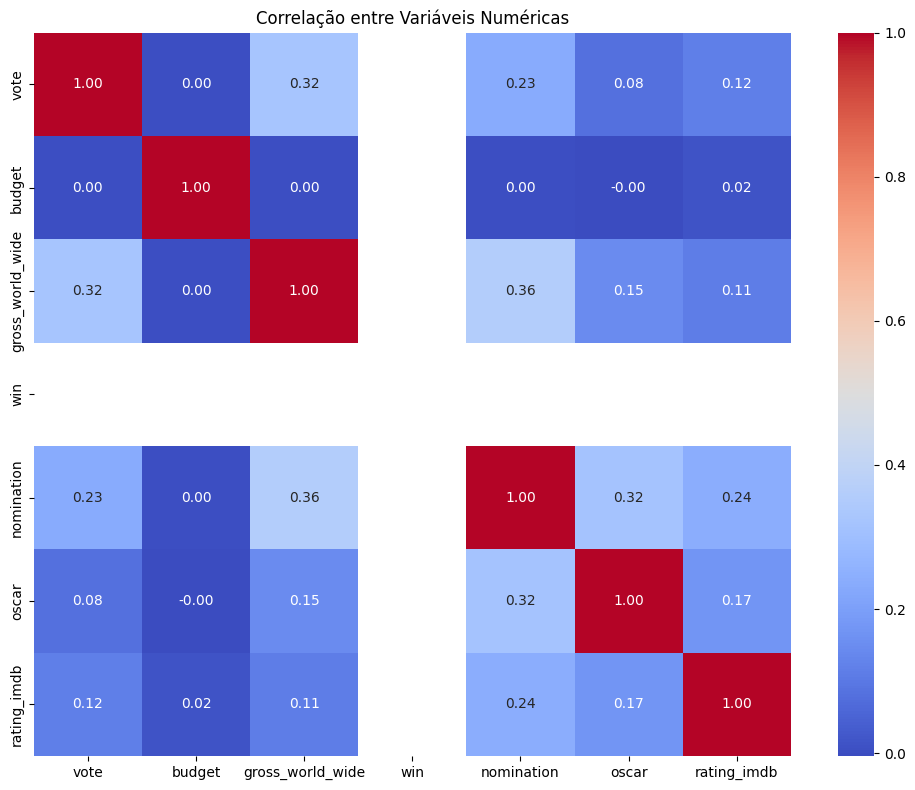

In [8]:
# Selecionando colunas numéricas relevantes como previsores, excluindo rating_imdb
# já que agora estamos prevendo uma categoria derivada dele
numeric_columns = ['vote', 'budget', 'gross_world_wide', 'win', 'nomination', 'oscar']

# Verificando correlação entre as variáveis numéricas
correlation_matrix = df[numeric_columns + ['rating_imdb']].corr()
print("Matriz de correlação:")
print(correlation_matrix)

# Visualizando mapa de calor da correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlação entre Variáveis Numéricas')
plt.tight_layout()
plt.show()

In [9]:
# Função para converter duração no formato "1h 38m" para minutos
def extract_duration_minutes(duration_str):
    if pd.isna(duration_str):
        return 0.0
        
    hours = 0
    minutes = 0
    
    # Procura por horas (padrão: Xh)
    hour_match = re.search(r'(\d+)h', str(duration_str))
    if hour_match:
        hours = int(hour_match.group(1))
    
    # Procura por minutos (padrão: Xm)
    minute_match = re.search(r'(\d+)m', str(duration_str))
    if minute_match:
        minutes = int(minute_match.group(1))
    
    return hours * 60 + minutes

# Adicionando coluna com duração em minutos
df['duration_minutes'] = df['duration'].apply(extract_duration_minutes)

# Verificando o resultado
print("Exemplos de conversão de duração:")
df[['duration', 'duration_minutes']].head()

Exemplos de conversão de duração:


,duration,duration_minutes
0,1h 38m,98.0
1,1h 30m,90.0
2,1h 30m,90.0
3,1h 49m,109.0
4,1h 15m,75.0


## D) Pré-processamento dos dados para o novo modelo

In [10]:
# Preparando os dados para o modelo
predictors_cols = numeric_columns + ['duration_minutes']

# Removendo linhas com rating_category nulo
df_clean = df.dropna(subset=['rating_category'])
print(f"Total de amostras após remover valores nulos: {len(df_clean)}")

# Preparando features (X) e target (y)
X = df_clean[predictors_cols].copy()
y = df_clean['rating_category']

# Codificando o target categórico
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Lidando com valores faltantes usando a mediana
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Normalizando os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Verificando a distribuição das classes
print("\nDistribuição das classes:")
print(pd.Series(y_encoded).value_counts())

Total de amostras após remover valores nulos: 33462

Distribuição das classes:
2    20137
0     7722
1     5603
Name: count, dtype: int64


In [11]:
# Aplicando undersampling para balancear as classes
rus = RandomUnderSampler(random_state=42)
X_balanced, y_balanced = rus.fit_resample(X_scaled, y_encoded)

# Verificando a distribuição após o balanceamento
print("Distribuição de classes após balanceamento:")
print(pd.Series(y_balanced).value_counts())

# Verificando as dimensões após o balanceamento
print(f"\nDimensões dos dados balanceados: {X_balanced.shape}")

Distribuição de classes após balanceamento:
0    5603
1    5603
2    5603
Name: count, dtype: int64

Dimensões dos dados balanceados: (16809, 7)


## E) Divisão em conjuntos de treino e teste

In [12]:
# Dividindo os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced
)

print(f"Tamanho do conjunto de treino: {X_train.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")

Tamanho do conjunto de treino: (11766, 7)
Tamanho do conjunto de teste: (5043, 7)


## F) Implementação do algoritmo NN (Nearest Neighbor) com o novo alvo

Acurácia do NN (k=1): 0.4860

Matriz de confusão do NN:
[[931 272 478]
 [284 918 479]
 [532 547 602]]

Relatório de classificação:
              precision    recall  f1-score   support

        alto       0.53      0.55      0.54      1681
       baixo       0.53      0.55      0.54      1681
       médio       0.39      0.36      0.37      1681

    accuracy                           0.49      5043
   macro avg       0.48      0.49      0.48      5043
weighted avg       0.48      0.49      0.48      5043



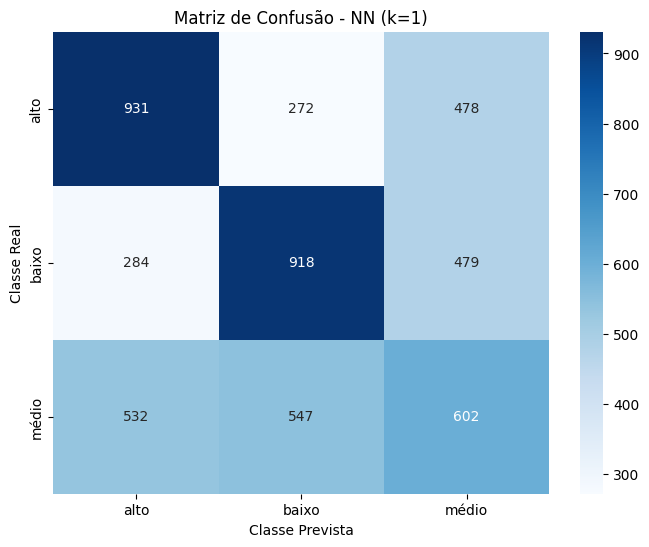

In [13]:
# Implementando o algoritmo NN (k=1)
nn = KNeighborsClassifier(n_neighbors=1)

# Treinando o modelo
nn.fit(X_train, y_train)

# Aplicando o modelo aos dados de teste
y_pred_nn = nn.predict(X_test)

# Calculando a acurácia
accuracy_nn = accuracy_score(y_test, y_pred_nn)
print(f"Acurácia do NN (k=1): {accuracy_nn:.4f}")

# Calculando e exibindo a matriz de confusão
confusion_nn = confusion_matrix(y_test, y_pred_nn)
print("\nMatriz de confusão do NN:")
print(confusion_nn)

# Exibindo relatório detalhado
print("\nRelatório de classificação:")
print(classification_report(y_test, y_pred_nn, 
                           target_names=label_encoder.classes_))

# Visualizando a matriz de confusão com um heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_nn, annot=True, fmt='d', cmap='Blues',
           xticklabels=label_encoder.classes_,
           yticklabels=label_encoder.classes_)
plt.title('Matriz de Confusão - NN (k=1)')
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')
plt.show()

## G) Implementação do algoritmo KNN (K-Nearest Neighbor) com o novo alvo

In [14]:
# Testando diferentes valores de K
k_values = [3, 5, 7, 9, 11]
results = {}

for k in k_values:
    # Criando e treinando o modelo KNN
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # Realizando predições
    y_pred = knn.predict(X_test)
    
    # Calculando acurácia
    accuracy = accuracy_score(y_test, y_pred)
    
    # Calculando matriz de confusão
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Armazenando os resultados
    results[k] = {
        'accuracy': accuracy,
        'confusion_matrix': conf_matrix
    }
    
    print(f"KNN com k={k}:")
    print(f"Acurácia: {accuracy:.4f}")
    print("Matriz de confusão:")
    print(conf_matrix)
    print("\n")

KNN com k=3:
Acurácia: 0.5086
Matriz de confusão:
[[1042  213  426]
 [ 339  954  388]
 [ 602  510  569]]


KNN com k=5:
Acurácia: 0.5300
Matriz de confusão:
[[1069  255  357]
 [ 259 1094  328]
 [ 593  578  510]]


KNN com k=7:
Acurácia: 0.5370
Matriz de confusão:
[[1052  247  382]
 [ 216 1124  341]
 [ 548  601  532]]


KNN com k=9:
Acurácia: 0.5449
Matriz de confusão:
[[1078  235  368]
 [ 228 1125  328]
 [ 554  582  545]]


KNN com k=11:
Acurácia: 0.5467
Matriz de confusão:
[[1078  271  332]
 [ 210 1139  332]
 [ 544  597  540]]




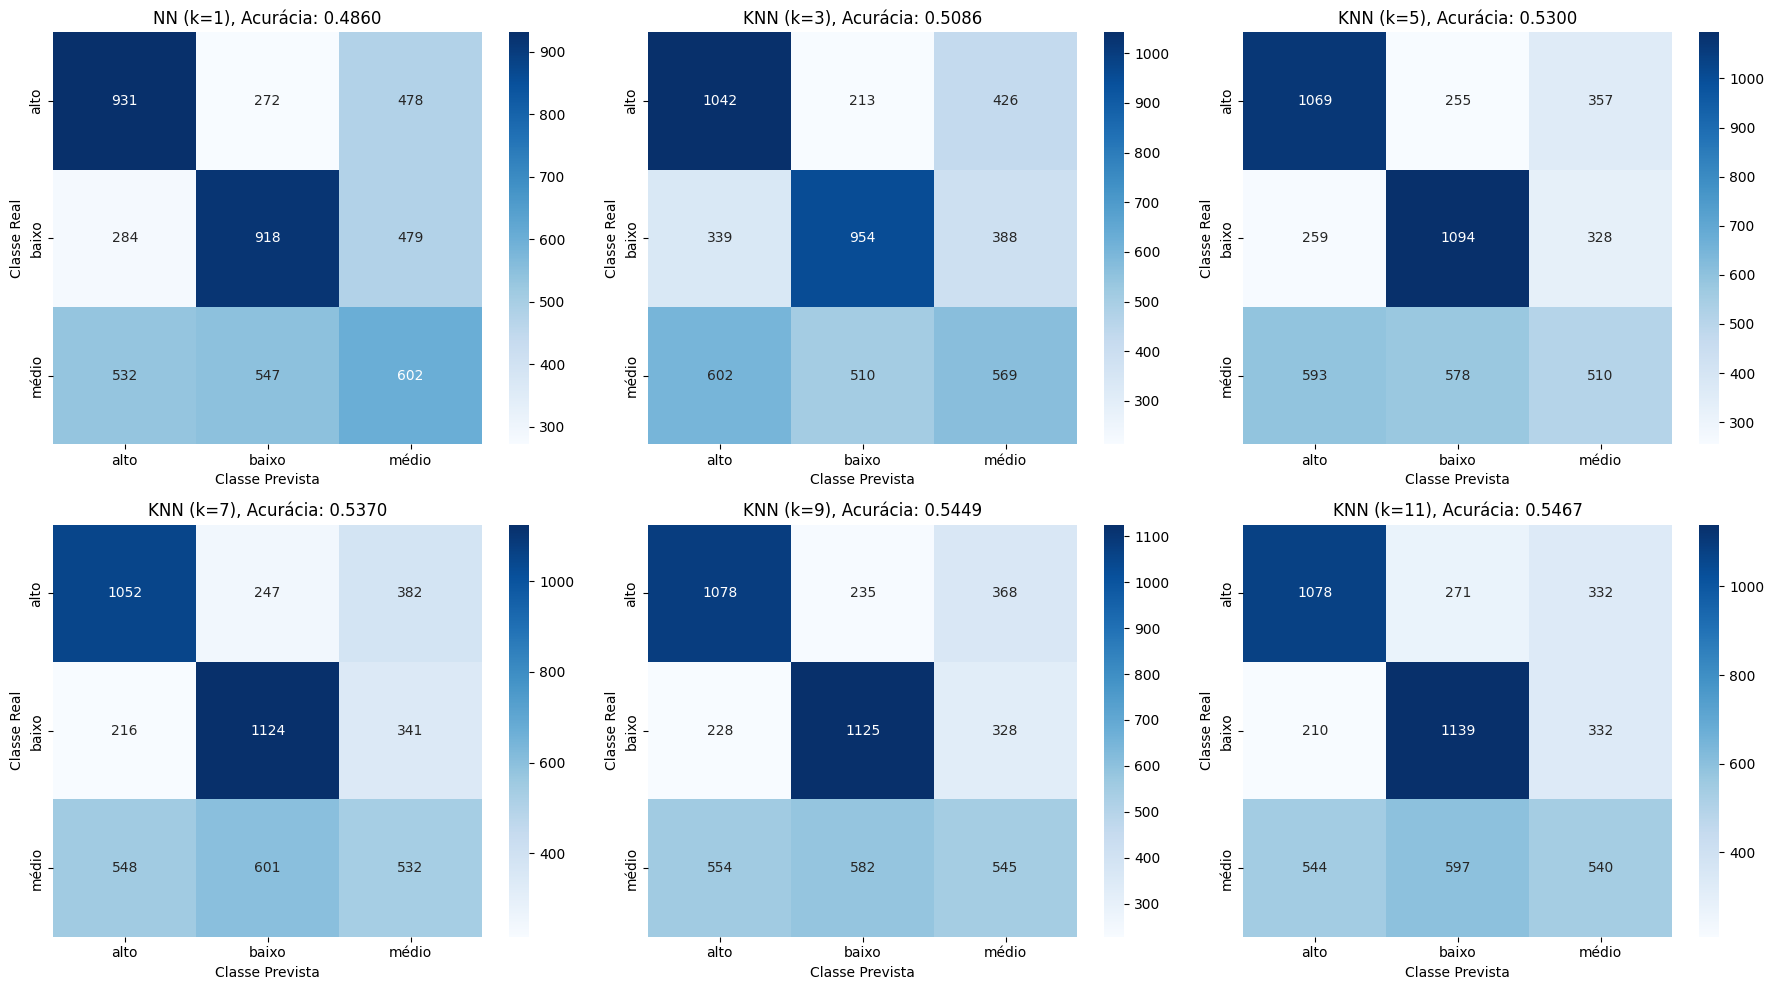

In [15]:
# Visualizando as matrizes de confusão para cada valor de K
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Matriz de confusão para NN (k=1)
sns.heatmap(confusion_nn, annot=True, fmt='d', cmap='Blues', ax=axes[0],
           xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
axes[0].set_title(f'NN (k=1), Acurácia: {accuracy_nn:.4f}')
axes[0].set_xlabel('Classe Prevista')
axes[0].set_ylabel('Classe Real')

# Matrizes de confusão para diferentes valores de K
for i, k in enumerate(k_values, 1):
    if i < len(axes):
        sns.heatmap(results[k]['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[i],
                   xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
        axes[i].set_title(f'KNN (k={k}), Acurácia: {results[k]["accuracy"]:.4f}')
        axes[i].set_xlabel('Classe Prevista')
        axes[i].set_ylabel('Classe Real')

plt.tight_layout()
plt.show()

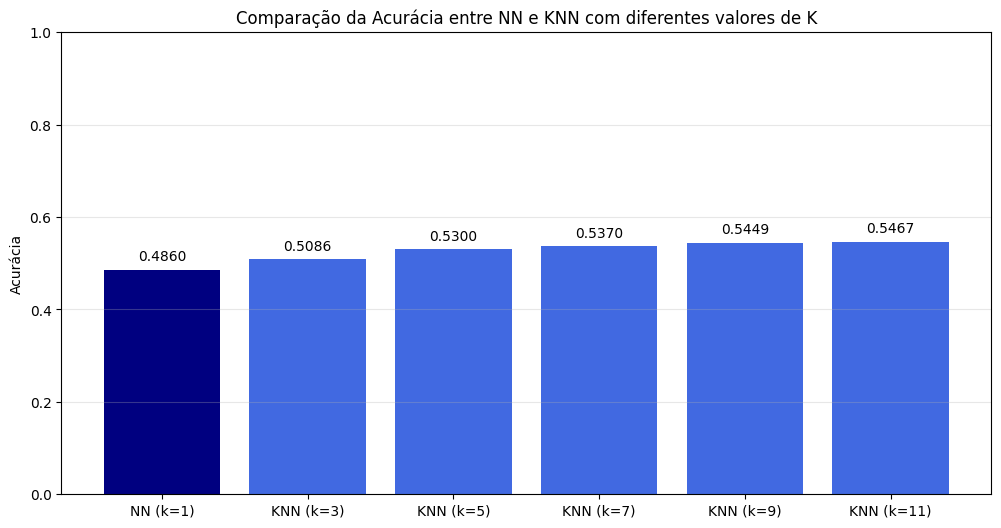

O melhor modelo é KNN (k=11) com acurácia de 0.5467


In [16]:
# Comparando a acurácia dos diferentes modelos
accuracies = [accuracy_nn] + [results[k]['accuracy'] for k in k_values]
model_names = ['NN (k=1)'] + [f'KNN (k={k})' for k in k_values]

plt.figure(figsize=(12, 6))
bar_colors = ['navy'] + ['royalblue' for _ in k_values]
plt.bar(model_names, accuracies, color=bar_colors)
plt.ylabel('Acurácia')
plt.title('Comparação da Acurácia entre NN e KNN com diferentes valores de K')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f'{acc:.4f}', ha='center')
plt.show()

# Determinando o melhor modelo
best_k = max(k_values, key=lambda k: results[k]['accuracy']) if k_values else 1
if not k_values or accuracy_nn >= max(results[k]['accuracy'] for k in k_values):
    best_model = "NN (k=1)"
    best_acc = accuracy_nn
else:
    best_model = f"KNN (k={best_k})"
    best_acc = results[best_k]['accuracy']
    
print(f"O melhor modelo é {best_model} com acurácia de {best_acc:.4f}")

## H) Feature Importance - Quais atributos são mais relevantes para prever a categoria de avaliação?

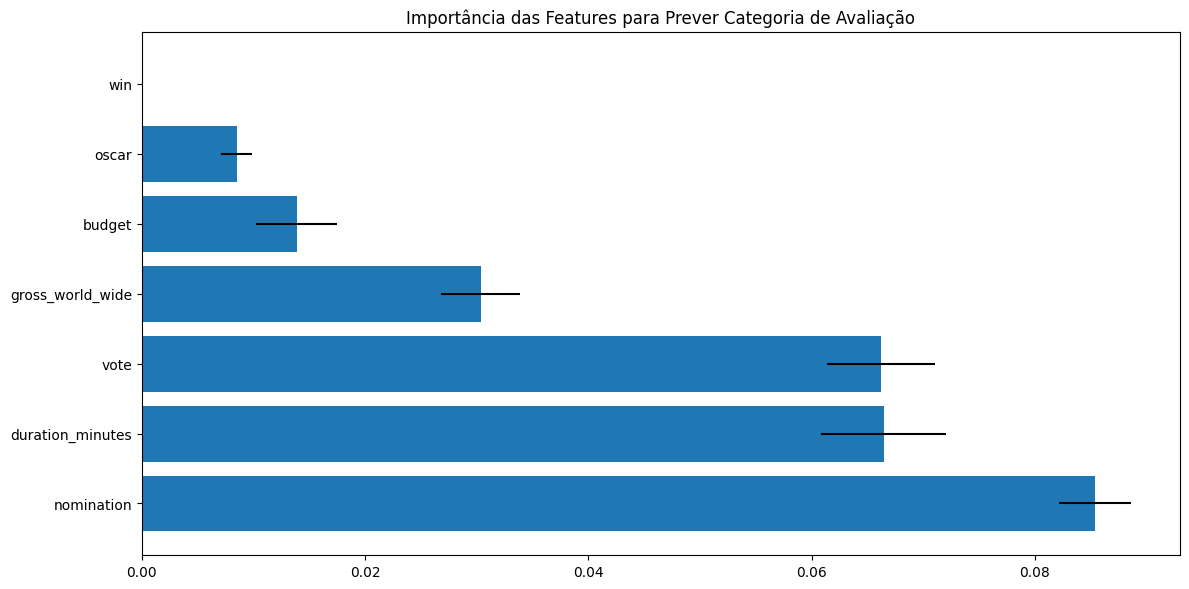

Importância das features (por permutação):
nomination: 0.0854 ± 0.0032
duration_minutes: 0.0665 ± 0.0056
vote: 0.0662 ± 0.0049
gross_world_wide: 0.0304 ± 0.0035
budget: 0.0139 ± 0.0036
oscar: 0.0085 ± 0.0014
win: 0.0000 ± 0.0000


In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

# Treinando um Random Forest para avaliar importância das features
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Calculando importância das features
importances = rf.feature_importances_

# Calculando importância por permutação (mais robusta)
perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

# Organizando as features por importância
feature_names = predictors_cols
sorted_indices = perm_importance.importances_mean.argsort()[::-1]

plt.figure(figsize=(12, 6))
plt.barh([feature_names[i] for i in sorted_indices], 
        perm_importance.importances_mean[sorted_indices],
        xerr=perm_importance.importances_std[sorted_indices])
plt.title('Importância das Features para Prever Categoria de Avaliação')
plt.tight_layout()
plt.show()

print("Importância das features (por permutação):")
for i in sorted_indices:
    print(f"{feature_names[i]}: {perm_importance.importances_mean[i]:.4f} ± {perm_importance.importances_std[i]:.4f}")

## I) Validação Cruzada para o melhor modelo KNN

In [104]:
from sklearn.model_selection import cross_val_score

# Definindo o melhor valor de K encontrado
best_knn = KNeighborsClassifier(n_neighbors=best_k)

# Realizando validação cruzada com 5 folds
scores = cross_val_score(best_knn, X_balanced, y_balanced, cv=5, scoring='accuracy')

print(f"Resultados da validação cruzada para KNN com k={best_k}:")
print(f"Acurácia por fold: {scores}")
print(f"Acurácia média: {scores.mean():.4f}")
print(f"Desvio padrão: {scores.std():.4f}")

Resultados da validação cruzada para KNN com k=11:
Acurácia por fold: [0.51285389 0.51513179 0.5174097  0.51692708 0.52441406]
Acurácia média: 0.5173
Desvio padrão: 0.0039


## C) Pré-processamento dos dados

Vamos realizar as seguintes etapas de pré-processamento:
1. Tratar a coluna 'duration' que está no formato "1h 38m"
2. Lidar com valores faltantes
3. Normalizar os dados para que todas as variáveis estejam na mesma escala